<a href="https://colab.research.google.com/github/BenUCL/Reef-acoustics-and-AI/blob/main/Code/Random_forests_compound_index_Aus_habitat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random forest classifiers**

This script splits the data into the same train/val/test sets as used for the pretrained CNN and trained CNN. It then trains on the training data and generates the accuracy for the validation data 50 times. The best performing model of the 50 repeats is used to inference on the test data and this accuracy is reported. This proces is repeatd 32 times to generate an accuracyfor all train/val/test split combinations. A confusion matrix of all these is then generated.

In [1]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# imports, probably some redundant packages
import sklearn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
from sklearn.model_selection import train_test_split
import statistics

from sklearn.metrics import confusion_matrix

import collections
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn
import matplotlib.pyplot as plt

from __future__ import division

In [3]:
# Upload the csv of features and copy the path
path = r'/content/drive/MyDrive/Reef soundscapes with AI/Results/full_dataset_features/compound_index_aus.csv'

num_classes = 2
labels = ['High fish', 'Low fish']

In [4]:
data = pd.read_csv (path)
df = data.reset_index() 
df = df.iloc[: , 2:] #remove additional index columns that got added at start
df

,minute,fish_ACI,fish_ACI_std,fish_ADI,fish_ADI_std,fish_H,fish_H_std,fish_Hf,fish_Hf_std,fish_M,...,full_H,full_H_std,full_Hf,full_Hf_std,full_M,full_M_std,full_BI,full_BI_std,NDSI,NDSI_std
0,SiteJdeployment2.1677983769.181103032034.wav,179.372677,26.483996,2.192782,0.063717,0.999843,0.000144,0.481993,0.030042,0.000181,...,0.999930,0.000041,0.726764,0.019765,0.002191,0.000152,6.620203,1.060968,0.695277,0.157566
1,SiteAdeployment1.805322778.181023172733.wav,168.801850,25.504564,1.969023,0.395328,0.999686,0.000299,0.445248,0.056819,0.000152,...,0.999946,0.000034,0.733206,0.039498,0.000549,0.000051,3.684730,0.750008,0.547568,0.218633
2,SiteIdeployment2.805322778.181102073302.wav,174.988720,24.714481,2.197048,0.295056,0.999771,0.000238,0.497067,0.028419,0.000167,...,0.999944,0.000031,0.731974,0.035967,0.000685,0.000051,4.032168,1.002873,0.574645,0.199514
3,SiteDdeployment4.805322778.181123173922.wav,165.651071,17.444454,1.960197,0.139087,0.999693,0.000213,0.427126,0.043692,0.000141,...,0.999937,0.000035,0.743762,0.024463,0.000573,0.000035,4.024412,0.804414,0.557476,0.186468
4,SiteEdeployment6.1677983769.181209085140.wav,180.360927,20.778196,2.119658,0.095857,0.999758,0.000208,0.465938,0.038046,0.000213,...,0.999944,0.000028,0.751055,0.020132,0.000948,0.000076,3.399768,0.976760,0.596916,0.143404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8970,SiteEdeployment4.1677983769.181123193512.wav,184.233526,22.297484,2.228646,0.043271,0.999820,0.000127,0.480210,0.036195,0.000186,...,0.999951,0.000024,0.742654,0.024411,0.001071,0.000087,4.076686,1.297506,0.571016,0.148354
8971,SiteBdeployment2.1678278701.181031081236.wav,182.347518,22.123627,2.138060,0.400734,0.999841,0.000106,0.497224,0.024994,0.000148,...,0.999947,0.000027,0.738500,0.025675,0.000756,0.000057,4.360228,1.096501,0.564474,0.149877
8972,SiteFdeployment1.805322778.181024160925.wav,169.744011,18.668109,1.920811,0.148186,0.999577,0.000351,0.422345,0.050649,0.000136,...,0.999957,0.000042,0.736660,0.042460,0.000351,0.000034,4.295832,0.988247,0.516021,0.216831
8973,SiteHdeployment2.805322778.181103064253.wav,172.621364,20.334057,2.113102,0.305195,0.999707,0.000298,0.448852,0.063027,0.000280,...,0.999914,0.000064,0.738087,0.059790,0.000930,0.000091,3.034830,0.899003,0.373618,0.247484


In [5]:
def get_class(filename):
    #find part of the name that corresponds to the deployment
     #adapted the get_identifier function above to only get class (e.g healthy)
    site = filename[0:5]
    return site
    
df_withclasses = df

# add a column to the DF that contains class
new_list = []
for i in range(len(df_withclasses)):
    new_list.append(get_class(df_withclasses['minute'][i]))

df_withclasses.insert(1, 'Class', new_list)
#df_withclasses.head(20)

indices_df = df_withclasses 

# Remove the 4 sites not being used for fish habitat comparison
indices_df.drop(indices_df.index[indices_df['Class'] == 'SiteC'], inplace=True)
indices_df.drop(indices_df.index[indices_df['Class'] == 'SiteD'], inplace=True)
indices_df.drop(indices_df.index[indices_df['Class'] == 'SiteE'], inplace=True)
indices_df.drop(indices_df.index[indices_df['Class'] == 'SiteI'], inplace=True)

# Rename the renaming sites to High or Low fish
indices_df['Class'] = indices_df['Class'].replace(['SiteA'],'Low fish')
indices_df['Class'] = indices_df['Class'].replace(['SiteB'],'Low fish')
indices_df['Class'] = indices_df['Class'].replace(['SiteG'],'Low fish')
indices_df['Class'] = indices_df['Class'].replace(['SiteJ'],'Low fish')

indices_df['Class'] = indices_df['Class'].replace(['SiteF'],'High fish')
indices_df['Class'] = indices_df['Class'].replace(['SiteH'],'High fish')
indices_df['Class'] = indices_df['Class'].replace(['SiteK'],'High fish')
indices_df['Class'] = indices_df['Class'].replace(['SiteL'],'High fish')

indices_df.reset_index(drop=True, inplace=True)
indices_df.head()

,minute,Class,fish_ACI,fish_ACI_std,fish_ADI,fish_ADI_std,fish_H,fish_H_std,fish_Hf,fish_Hf_std,...,full_H,full_H_std,full_Hf,full_Hf_std,full_M,full_M_std,full_BI,full_BI_std,NDSI,NDSI_std
0,SiteJdeployment2.1677983769.181103032034.wav,Low fish,179.372677,26.483996,2.192782,0.063717,0.999843,0.000144,0.481993,0.030042,...,0.999930,0.000041,0.726764,0.019765,0.002191,0.000152,6.620203,1.060968,0.695277,0.157566
1,SiteAdeployment1.805322778.181023172733.wav,Low fish,168.801850,25.504564,1.969023,0.395328,0.999686,0.000299,0.445248,0.056819,...,0.999946,0.000034,0.733206,0.039498,0.000549,0.000051,3.684730,0.750008,0.547568,0.218633
2,SiteBdeployment5.1677983769.181201071827.wav,Low fish,175.991643,20.887505,2.067315,0.143728,0.999749,0.000232,0.453967,0.057671,...,0.999950,0.000029,0.736850,0.028800,0.001101,0.000129,4.278120,0.978240,0.580337,0.142176
3,SiteAdeployment6.805322778.181208200239.wav,Low fish,181.623479,22.365652,2.178056,0.149959,0.999835,0.000163,0.488024,0.038268,...,0.999924,0.000050,0.750360,0.015946,0.001342,0.000162,4.511504,1.068721,0.629611,0.125260
4,SiteJdeployment3.1677983769.181110075705.wav,Low fish,178.154917,24.206607,2.194177,0.075626,0.999790,0.000179,0.464995,0.045202,...,0.999929,0.000060,0.740933,0.022895,0.001517,0.000112,4.166993,1.360326,0.666806,0.128720


In [6]:
def get_class(filename):
    #find part of the name that corresponds to the deployment
     #adapted the get_identifier function above to only get class (e.g healthy)
    site = filename[0:5]
    return site
    
df_withclasses = df

# add a column to the DF that contains class
new_list = []
for i in range(len(df_withclasses)):
    new_list.append(get_class(indices_df['minute'][i]))

indices_df.insert(1, 'Site', new_list)

In [9]:
def similar(x,y):
    si = 0
    for a,b in zip(x, y):
        if a == b:
            si += 1
    return (si/len(x)) * 100

In [10]:
all_saved_test_accs = []
whole_site_saved_test_accs = []
ConfusionMatrix = np.zeros((num_classes, num_classes), dtype=float)

for i in range(4):  #4 sites in the lowfish class
  low_fish = ['SiteA', 'SiteB', 'SiteG', 'SiteJ'] #the 4 low fish sites
  remove_low = low_fish[i] #select 1 to be the val site
  train_low_fish = low_fish 
  train_low_fish.remove(remove_low) #remove the val site to get the train lowfish sites
  #print(train_low_fish)
  for k in range(4): #4 sites in the highfish class
    thisCV_saved_test_accs = []
    thisCV_saved_test_day_accs = []

    high_fish = ['SiteH', 'SiteF', 'SiteK', 'SiteL'] #the 4 high fish sites
    remove_high = high_fish[k] #select 1 to be the test site
    train_high_fish = high_fish 
    train_high_fish.remove(remove_high) #remove the test site to get the train lowfish sites
    #print(train_high_fish)
    
    # Make the train df's, starting with low fish then append high fish
    train_df = indices_df.loc[indices_df['Site'].isin(train_low_fish)]
    train_df = train_df.append(indices_df.loc[indices_df['Site'].isin(train_high_fish)])

    # create val df that is 50:50 low and high fish
    lowfish_df = indices_df.loc[indices_df['Site'] == remove_low]
    highfish_df = indices_df.loc[indices_df['Site'] == remove_high]
    val_df = lowfish_df.iloc[::2,:] # take every other lowfish minute and create a new df
    val_df = val_df.append(highfish_df.iloc[::2,:])
    # create test df's that is the ramaining 50:50 low and high fish
    test_df = lowfish_df.iloc[1::2,:] # take every other lowfish minute and create a new df
    test_df = test_df.append(highfish_df.iloc[1::2,:])

    #shuffle the df's so the RF's aren't first fed all low then fed all high fish after
    np.random.seed(123) 
    train_df = train_df.sample(frac=1)
    val_df = val_df.sample(frac=1)
    test_df = test_df.sample(frac=1)
    np.random.seed() #now lift the seed so that randomisation can be used again in the rest of the script

    # Make new df's of the feats and labels to feed random forests
    train_feats = train_df.iloc[:, 3:].to_numpy()
    train_labels = train_df.iloc[:, 2].to_numpy()

    val_feats = val_df.iloc[:, 3:].to_numpy()
    val_labels = val_df.iloc[:, 2].to_numpy()

    test_feats = test_df.iloc[:, 3:].to_numpy()
    test_labels = test_df.iloc[:, 2].to_numpy()

    
    val_accuracy_score = 0
    for k in range(50):              # Picked 50 as 50 epochs used in NN
      #Training on train data
      model = RandomForestClassifier(n_jobs = -1, random_state=k)
      model.fit(train_feats, train_labels)

      #Inferencing on validation data
      new_val_acc = model.score(val_feats, val_labels)

      #If val acc improved, inference on test data
      if new_val_acc >  val_accuracy_score:
        #save the new high score for val
        val_accuracy_score = new_val_acc 

        #get 1min acc for test data
        test_acc = model.score(test_feats, test_labels) 
        
        #get the acc when using the most common prediction across all minutes in a day for each site
        test_predictions = model.predict(test_feats)

        # get confusion matrix values
        best_ConfusionMatrix = confusion_matrix(test_labels, test_predictions, labels = labels) ###

        if  similar(test_labels, test_predictions) >= 50:
          whole_site_acc = 1
        else:
          whole_site_acc = 0
        
      
    #Save best results
    ConfusionMatrix = np.add(ConfusionMatrix, best_ConfusionMatrix) ###
    thisCV_saved_test_accs.append(test_acc)
    all_saved_test_accs.append(test_acc)
    thisCV_saved_test_day_accs.append(whole_site_acc)
    whole_site_saved_test_accs.append(whole_site_acc)

    print('Accuracies for 1min files from this site:')
    print(thisCV_saved_test_accs)
    print('Accuracies for the whole site [0 or 1]:')
    print(thisCV_saved_test_day_accs)
    thisCV_saved_test_accs = []
    thisCV_saved_test_day_accs = []
    print()

pt1_saved_test_accs = all_saved_test_accs
pt1_whole_site_saved_test_accs = whole_site_saved_test_accs


# this will run all the lowfish sites as val, then repeat the whole thing below but swap the highfish to be in the top loop and low fish in bottom loop
    
    
print('Part 1 Completed RFs:')
print(len(all_saved_test_accs))

def Average(lst):
    return sum(lst) / len(lst)
mean_accuracy = Average(all_saved_test_accs)
stdev = np.std(all_saved_test_accs)

print('1min saved_test_accs: ')
print(all_saved_test_accs)
result = 'Mean accuracy for 1min files with standard deviation = {} (±{})'.format(str(mean_accuracy), str(stdev))
print(result)     



print('Part 1 Completed RFs:')
print(len(whole_site_saved_test_accs))

def Average(lst):
    return sum(lst) / len(lst)
mean_accuracy = Average(whole_site_saved_test_accs)
stdev = np.std(whole_site_saved_test_accs)

print('Whole site saved test_accs: ')
print(whole_site_saved_test_accs)
result = 'Mean accuracy for whole sites with standard deviation = {} (±{})'.format(str(mean_accuracy), str(stdev))
print(result)


all_saved =  mean_accuracy
stdev_pt1 = stdev








#pt2
all_saved_test_accs = []
whole_site_saved_test_accs = []
#ConfusionMatrix = np.zeros((num_classes, num_classes), dtype=float)

for i in range(4):  #4 sites in the lowfish class
  high_fish =  ['SiteH', 'SiteF', 'SiteK', 'SiteL'] #the 4 high fish sites
  remove_high = high_fish[i] #select 1 to be the val site
  train_high_fish = high_fish 
  train_high_fish.remove(remove_high) #remove the val site to get the train lowfish sites
  for k in range(4): #4 sites in the highfish class
    thisCV_saved_test_accs = []
    thisCV_saved_test_day_accs = []

    low_fish = ['SiteA', 'SiteB', 'SiteG', 'SiteJ'] #the 4 low fish sites
    remove_low = low_fish[k] #select 1 to be the test site
    train_low_fish = low_fish 
    train_low_fish.remove(remove_low) #remove the test site to get the train lowfish sites
    #print(train_high_fish)
    
    # Make the train df's, starting with low fish then append high fish
    train_df = indices_df.loc[indices_df['Site'].isin(train_low_fish)]
    train_df = train_df.append(indices_df.loc[indices_df['Site'].isin(train_high_fish)])

    # create val df that is 50:50 low and high fish
    lowfish_df = indices_df.loc[indices_df['Site'] == remove_low]
    highfish_df = indices_df.loc[indices_df['Site'] == remove_high]
    val_df = lowfish_df.iloc[1::2,:] # take every other lowfish minute and create a new df
    val_df = val_df.append(highfish_df.iloc[1::2,:])
    # create test df's that is the ramaining 50:50 low and high fish
    test_df = lowfish_df.iloc[::2,:] # take every other lowfish minute and create a new df
    test_df = test_df.append(highfish_df.iloc[::2,:])

    #shuffle the df's so the RF's aren't first fed all low then fed all high fish after
    np.random.seed(123) 
    train_df = train_df.sample(frac=1)
    val_df = val_df.sample(frac=1)
    test_df = test_df.sample(frac=1)
    np.random.seed() #now lift the seed so that randomisation can be used again in the rest of the script

    # Make new df's of the feats and labels to feed random forests
    train_feats = train_df.iloc[:, 3:].to_numpy()
    train_labels = train_df.iloc[:, 2].to_numpy()

    val_feats = val_df.iloc[:, 3:].to_numpy()
    val_labels = val_df.iloc[:, 2].to_numpy()

    test_feats = test_df.iloc[:, 3:].to_numpy()
    test_labels = test_df.iloc[:, 2].to_numpy()

    
    val_accuracy_score = 0
    for k in range(50):              # Picked 50 as 50 epochs used in NN
      #Training on train data
      model = RandomForestClassifier(n_jobs = -1, random_state=k)
      model.fit(train_feats, train_labels)

      #Inferencing on validation data
      new_val_acc = model.score(val_feats, val_labels)

      #If val acc improved, inference on test data
      if new_val_acc >  val_accuracy_score:
        #save the new high score for val
        val_accuracy_score = new_val_acc 

        #get 1min acc for test data
        test_acc = model.score(test_feats, test_labels) 
        
        #get the acc when using the most common prediction across all minutes in a day for each site
        test_predictions = model.predict(test_feats)

        # get confusion matrix values
        best_ConfusionMatrix = confusion_matrix(test_labels, test_predictions, labels = labels) ###

        if  similar(test_labels, test_predictions) >= 50:
          whole_site_acc = 1
        else:
          whole_site_acc = 0
        
      
    #Save best results
    ConfusionMatrix = np.add(ConfusionMatrix, best_ConfusionMatrix) ###
    thisCV_saved_test_accs.append(test_acc)
    all_saved_test_accs.append(test_acc)
    thisCV_saved_test_day_accs.append(whole_site_acc)
    whole_site_saved_test_accs.append(whole_site_acc)

    print('Accuracies for 1min files from this site:')
    print(thisCV_saved_test_accs)
    print('Accuracies for the whole site [0 or 1]:')
    print(thisCV_saved_test_day_accs)
    thisCV_saved_test_accs = []
    thisCV_saved_test_day_accs = []
    print()


both_saved_test_accs = pt1_saved_test_accs + all_saved_test_accs 
both_whole_site_saved_test_accs = pt1_whole_site_saved_test_accs + whole_site_saved_test_accs
    
print('Part 2 Completed RFs:')
print(len(both_saved_test_accs))

def Average(lst):
    return sum(lst) / len(lst)
mean_accuracy = Average(both_saved_test_accs)
stdev = np.std(both_saved_test_accs)

print('1min saved_test_accs: ')
print(both_saved_test_accs)
result = 'Mean accuracy for 1min files with standard deviation = {} (±{})'.format(str(mean_accuracy), str(stdev))
print(result) 




print('Part 2 Completed RFs:')
print(len(both_whole_site_saved_test_accs))

def Average(lst):
    return sum(lst) / len(lst)
mean_accuracy = Average(both_whole_site_saved_test_accs)
stdev = np.std(both_whole_site_saved_test_accs)

print('Whole site saved test_accs: ')
print(both_whole_site_saved_test_accs)
result = 'Mean accuracy for whole sites with standard deviation = {} (±{})'.format(str(mean_accuracy), str(stdev))
print(result) 

print()
print(repr(ConfusionMatrix))


Accuracies for 1min files from this site:
[0.6846965699208444]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.6018641810918774]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.724]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.5514511873350924]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.7957142857142857]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.696969696969697]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.9176300578034682]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.66]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.6082089552238806]
Accuracies for the whole site [0 or 1]:
[1]

Accuracies for 1min files from this site:
[0.56336260978

# **Analysis for colab only**

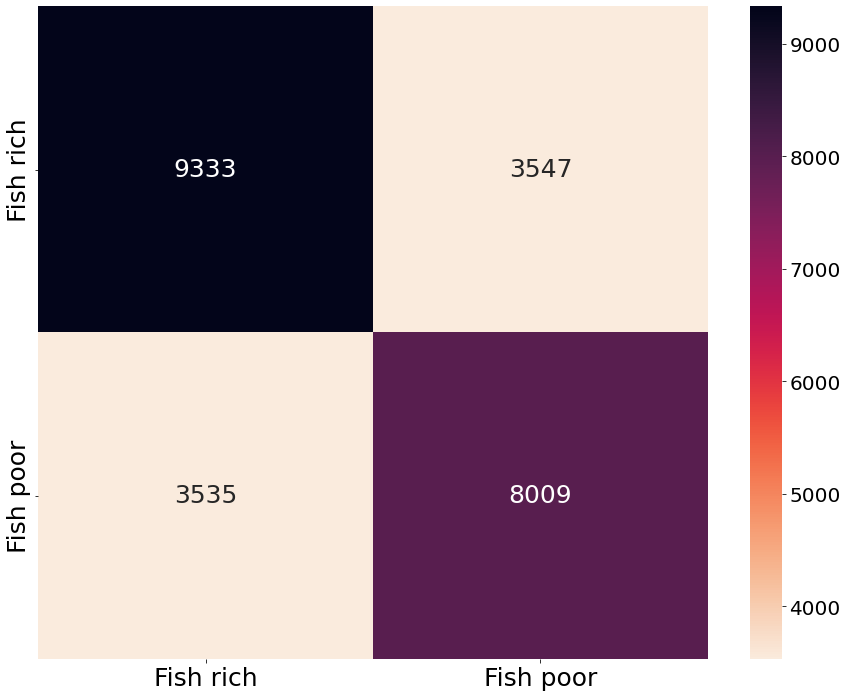

In [14]:
#HPCconfusionmatrix = [[9333., 3547.],
 #      [3535., 8009.]]

array = ConfusionMatrix

df_cm = pd.DataFrame(array, index = ["Fish rich", "Fish poor"],
                  columns = ["Fish rich", "Fish poor"])
plt.figure(figsize = (15,12))
cmap = sn.cm.rocket_r
ax = sn.heatmap(df_cm, annot=True, annot_kws={"fontsize":25}, fmt='g', cmap = cmap)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 25)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 25)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)